# 作業 : (Kaggle)鐵達尼生存預測

# [作業目標]
- 試著模仿範例寫法, 在鐵達尼生存預測中, 練習特徵重要性的寫作與觀察

# [作業重點]
- 仿造範例, 完成特徵重要性的計算, 並觀察對預測結果的影響 (In[3]-[5], Out[3]-[5]) 
- 仿造範例, 將兩個特徵重要性最高的特徵重組出新特徵, 並觀察對預測結果的影響 (In[8], Out[8]) 

In [1]:
# 做完特徵工程前的所有準備 (與前範例相同)
import pandas as pd
import numpy as np
import copy
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

data_path = 'data/'
df = pd.read_csv(data_path + 'titanic_train.csv')

train_Y = df['Survived']
df = df.drop(['PassengerId', 'Survived'] , axis=1)
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
# 因為需要把類別型與數值型特徵都加入, 故使用最簡版的特徵工程
LEncoder = LabelEncoder()
MMEncoder = MinMaxScaler()
for c in df.columns:
    df[c] = df[c].fillna(-1)
    if df[c].dtype == 'object':
        df[c] = LEncoder.fit_transform(list(df[c].values))
    df[c] = MMEncoder.fit_transform(df[c].values.reshape(-1, 1))
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1.0,0.121348,1.0,0.283951,0.125,0.0,0.769118,0.014151,0.000000,1.000000
1,0.0,0.213483,0.0,0.481481,0.125,0.0,0.876471,0.139136,0.557823,0.333333
2,1.0,0.396629,0.0,0.333333,0.000,0.0,0.983824,0.015469,0.000000,1.000000
3,0.0,0.305618,0.0,0.444444,0.125,0.0,0.072059,0.103644,0.380952,1.000000
4,1.0,0.016854,1.0,0.444444,0.000,0.0,0.694118,0.015713,0.000000,1.000000


In [3]:
# 隨機森林擬合後, 將結果依照重要性由高到低排序 
estimator = RandomForestClassifier()
estimator.fit(df.values, train_Y)
feats = pd.Series(data=estimator.feature_importances_, index=df.columns)
feats = feats.sort_values(ascending=False)
feats

Sex         0.253487
Ticket      0.156124
Name        0.143075
Fare        0.114477
Age         0.113156
Pclass      0.073600
Cabin       0.070812
Parch       0.034284
SibSp       0.026368
Embarked    0.014617
dtype: float64

## 先用隨機森林對鐵達尼生存預測做訓練，再用其特徵重要性回答下列問題

# 作業1
* 將特徵重要性較低的一半特徵刪除後，再做生存率預估，正確率是否有變化?
>雖然範例與作業當中, 看似高重要性特徵的預估正確率較高較低有所不同, 但沒有差距太大
而且是只使用一半特徵的結果, 表示高重要特徵的資訊密度是高的, 使用較少特徵, 泛化能力(對外部資料預測力)也會提升,
因此只要不要刪到一半那麼多, 仍可能是適當的特徵選擇方式

In [4]:
# 原始特徵 + 隨機森林
train_X = MMEncoder.fit_transform(df)
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.8193878119162902

In [5]:
# 高重要性特徵 + 隨機森林
high_feature = list(feats[:5].index)
train_X = MMEncoder.fit_transform(df[high_feature])
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.8125769074047081

# 作業2
* 將特徵重要性最高的兩個特徵做特徵組合，是否能再進一步提升預測力?
>範例中我們可以看出, 加.乘.除三個特徵加上去後, 有稍微好一點點
而作業中只挑選加與乘, 是否提升也有隨機性(可能更好或更差, 建議同學多執行幾次觀察)
這些特徵的組合, 未必有一定的方式, 解答只是舉例, 請同學自行決定要採用的方式
也許同學能自行開發出更有意義的特徵
另外若能參考領域知識, 還可能做出更有用的特徵組合

In [6]:
# 觀察重要特徵與目標的分布
# 第一名              
import seaborn as sns
import matplotlib.pyplot as plt
sns.violinplot(x=train_Y, y=df['Sex'], fit_reg=False, scale="width")
plt.show()

<Figure size 640x480 with 1 Axes>

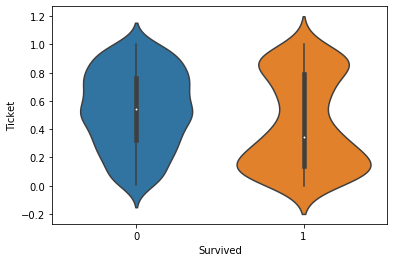

In [7]:
# 第二名 : Ticket       
sns.violinplot(x=train_Y, y=df['Ticket'], fit_reg=False)
plt.show()

In [8]:
# 製作二特徵 : 加, 乘
df['Add_char'] = (df['Ticket'] + df['Name']) / 2
df['Multi_char'] = df['Ticket'] * df['Name']
train_X = MMEncoder.fit_transform(df)
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.819293443086304